# Семинар 2. `sklearn` и линейная регрессия

На этом семинаре мы:
* Узнаем о том, что такое переобучение, что такое линейная регрессия и как не допустить переобучения в линейных моделях;
* Обучим линейную регрессию для предсказания цены дома;
* Научимся работать с разными типами признаков;
* Поймем, в чем отличие между разными регуляризаторами;
* Научимся пользоваться основными инструментами в `sklearn`: моделями, трансформерами и pipeline

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
warnings.simplefilter("ignore")
%matplotlib inline

sns.set(style="darkgrid")

# Часть 0. Введение в линейные модели

Напомним, что линейная регрессия - это модель следующего вида:
$$a(x) = \langle w, x \rangle + w_0$$
где $w \in \mathbb{R}^d$, $w_0 \in \mathbb{R}$. Обучить линейную регрессию - значит найти $w$ и $w_0$.

В машинном обучении часто говорят об *обобщающей способности модели*, то есть о способности модели работать на новых, тестовых данных хорошо. Если модель будет идеально предсказывать выборку, на которой она обучалась, но при этом просто ее запомнит, не "вытащив" из данных никакой закономерности, от нее будет мало толку. Такую модель называет *переобученной*: она слишком подстроилась под обучающие примеры, не выявив никакой полезной закономерности, которая позволила бы ей совершать хорошие предсказания на данных, которые она ранее не видела.

Рассмотрим следующий пример, на котором будет хорошо видно, что значит переобучение модели. Для этого нам понадобится сгенерировать синтетические данные. Рассмотрим зависимость $y(x) = \cos(1.5\pi x)$, $y$ - целевая переменная, а $x$ - объект (просто число от 0 до 1). В жизни мы наблюдаем какое-то конечно количество пар объект-таргет, поэтому смоделируем это, взяв 30 случайных точек $x_i$ в отрезке $[0;1]$. Более того, в реальной жизни целевая переменная может быть зашумленной (измерения в жизни не всегда точны), смоделируем это, зашумив значение функции нормальным шумом: $\tilde{y}_i = y(x_i) + \mathcal{N}(0, 0.01)$.

Попытаемся обучить три разных линейных модели: признаки для первой -  $\{x\}$, для второй - $\{x, x^2, x^3, x^4\}$, для третьей - $\{x, \dots, x^{20}\}$

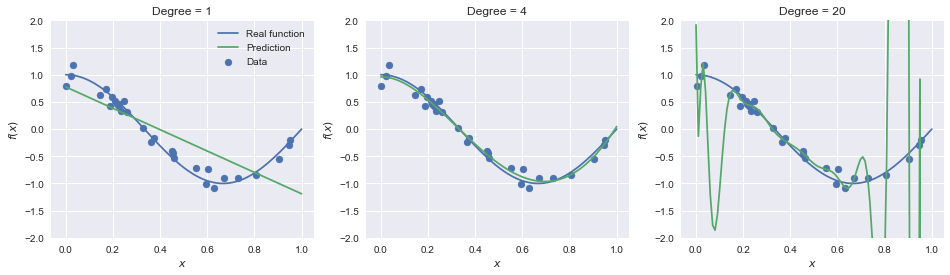

In [4]:
from sklearn.linear_model import LinearRegression

np.random.seed(36)
x = np.linspace(0, 1, 100)
y = np.cos(1.5 * np.pi * x)

x_objects = np.random.uniform(0, 1, size=30)
y_objects = np.cos(1.5 * np.pi * x_objects) + np.random.normal(scale=0.1, size=x_objects.shape)

from sklearn.preprocessing import PolynomialFeatures
fig, axs = plt.subplots(figsize=(16, 4), ncols=3)
for i, degree in enumerate([1, 4, 20]):
    X_objects = PolynomialFeatures(degree).fit_transform(x_objects[:, None])
    X = PolynomialFeatures(degree).fit_transform(x[:, None])
    regr = LinearRegression().fit(X_objects, y_objects)
    y_pred = regr.predict(X)
    axs[i].plot(x, y, label="Real function")
    axs[i].scatter(x_objects, y_objects, label="Data")
    axs[i].plot(x, y_pred, label="Prediction")
    if i == 0:
        axs[i].legend()
    axs[i].set_title("Degree = %d" % degree)
    axs[i].set_xlabel("$x$")
    axs[i].set_ylabel("$f(x)$")
    axs[i].set_ylim(-2, 2)

**Вопрос 1**: Почему первая модель получилась плохой, а третья переобучилась?

Чтобы избежать переобучения, модель регуляризуют. Обычно переобучения в линейных моделях связано с большими весами, а поэтому модель часто штрафуют за большие значения весов, добавляя к функционалу качества, например, квадрат $\ell^2$-нормы вектора $w$:

$$Q_{reg}(X, y, a) = Q(X, y, a) + \lambda \|w\|_2^2$$

Это слагаемое называют $\ell_2$-регуляризатором, а коэффициент $\lambda$ - коэффициентом регуляризации. Более подробно о регуляризации и переобучении вы узнаете из лекций.

**Вопрос 2**: Почему большие веса в линейной модели - плохо?

**Вопрос 3**: Почему регуляризовать $w_0$ - плохая идея?

**Вопрос 4**: На что влияет коэффициент $\lambda$? Что будет происходить с моделью, если $\lambda$ начать уменьшать? Что будет, если $\lambda$ сделать слишком большим?

# Часть 1. Загружаем данные

Мы будем работать с данными из соревнования [House Prices: Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview), в котором требовалось предсказать стоимость жилья. Давайте сначала загрузим и немного изучим данные (`train.csv` со страницы соревнования).

In [14]:
data = pd.read_csv("train.csv")
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [6]:
data.shape

(1460, 81)

Первое, что стоит заметить, - у нас в данных есть уникальное для каждого объекта поле id. Обычно такие поля только мешают и способствуют переобучению. Удалим это поле из данных.

Разделим данные на обучающую и тестовую выборки. Для простоты не будем выделять дополнительно валидационную выборку (хотя это обычно стоит делать, она нужна для подбора гиперпараметров модели, то есть параметров, которые нельзя подбирать по обучающей выборке). Дополнительно нам придется отделить значения целевой переменной от данных.

**Вопрос 1**: Почему поля типа id могут вызвать переобучение модели (не обязательно линейной)?

**Вопрос 2**: Почему стоит дополнительно отделять валидационную выборку?

**Вопрос 3**: Обратите внимание на фиксацию `random_state` при сплите данных. Почему это важно?

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [15]:
from sklearn.model_selection import train_test_split

data = data.drop(["Id"], axis=1)

y = data["SalePrice"]
X = data.drop(["SalePrice"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

Посмотрим сначала на значения целевой переменной.

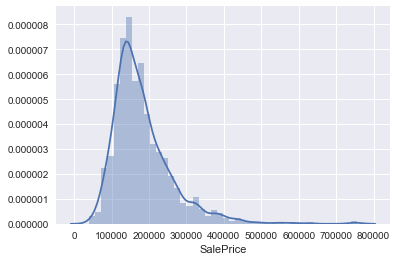

In [17]:
sns.distplot(y_train)

Судя по гистограмме, у нас есть примеры с нетипично большой стоимостью, что может помешать нам, если наша функция потерь слишком чувствительна к выбросам. В дальнейшем мы рассмотрим способы, как минимизировать ущерб от этого.

Так как для решения нашей задачи мы бы хотели обучить линейную регрессию, было бы хорошо найти признаки, "наиболее линейно" связанные с целевой переменной, иначе говоря, посмотреть на коэффициент корреляции Пирсона между признаками и целевой переменной. Заметим, что не все признаки являются числовыми, пока что мы не будем рассматривать такие признаки.

**Вопрос**: Что означает, что коэффициент корреляции Пирсона между двумя случайными величинами равен 1? -1? 0?

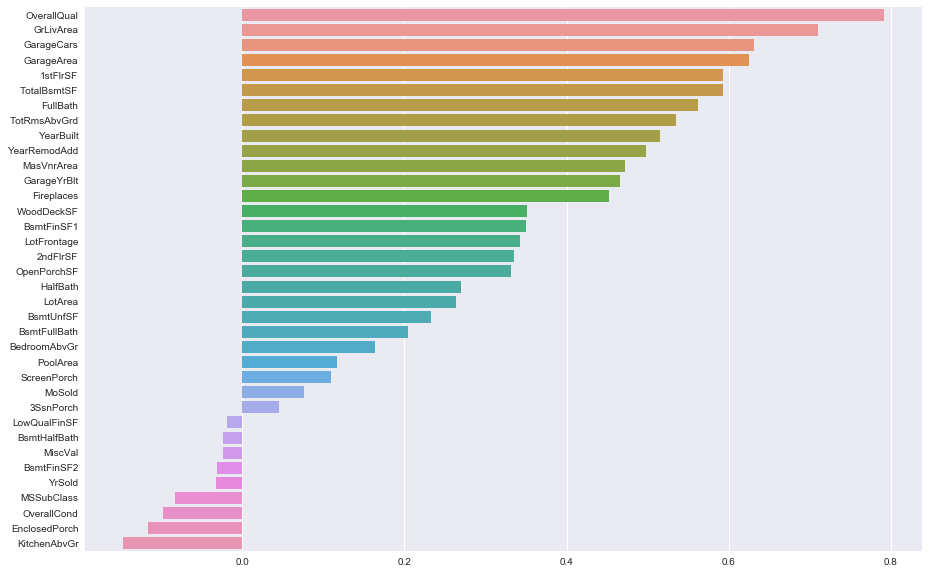

In [18]:
numeric_data = X_train.select_dtypes([np.number])
numeric_data_mean = numeric_data.mean()
numeric_features = numeric_data.columns

X_train = X_train.fillna(numeric_data_mean)
X_test = X_test.fillna(numeric_data_mean)

correlations = {
    feature: np.corrcoef(X_train[feature], y_train)[0][1]
    for feature in numeric_features
}
sorted_correlations = sorted(correlations.items(), key=lambda x: x[1], reverse=True)
features_order = [x[0] for x in sorted_correlations]
correlations = [x[1] for x in sorted_correlations]

plot = sns.barplot(y=features_order, x=correlations)
plot.figure.set_size_inches(15, 10)

Посмотрим на признаки из начала списка. Для этого нарисуем график заивимости целевой переменной от каждого из признаков. На этом графике каждая точка соответствует паре признак-таргет (такие графики называются scatter-plot).

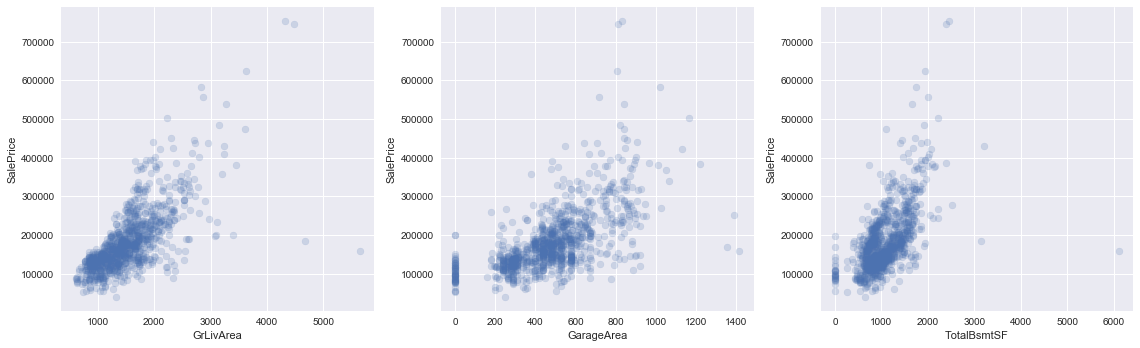

In [19]:
fig, axs = plt.subplots(figsize=(16, 5), ncols=3)
for i, feature in enumerate(["GrLivArea", "GarageArea", "TotalBsmtSF"]):
    axs[i].scatter(X_train[feature], y_train, alpha=0.2)
    axs[i].set_xlabel(feature)
    axs[i].set_ylabel("SalePrice")
plt.tight_layout()

Видим, что между этими признаками и целевой переменной действительно наблюдается линейная зависимость.

# Часть 2. Первая модель

*Немного об обучении моделей*. В арсенале дата-саентиста кроме `pandas` и `matplotlib` должны быть библиотеки, позволяющие обучать модели. Для простых моделей (линейные модели, решающее дерево, ...) отлично подходит `sklearn`: в нем очень понятный и простой интерфейс. Несмотря на то, что в `sklearn` есть реализация бустинга и простых нейронных сетей, ими все же не пользуются и предпочитают специализированные библиотеки: `XGBoost`, `LightGBM` и пр. для градинетного бустинга над деревьями, `PyTorch`, `Tensorflow` и пр. для нейронных сетей. Так как мы будем обучать линейную регрессию, нам подойдет реализация из `sklearn`.

Попробуем обучить линейную регрессию на числовых признаках из нашего датасета. В `sklearn` есть несколько классов, реализующих линейную регрессию:
* [`LinearRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) - "классическая" линейная регрессия с оптимизацией MSE. Веса находятся как точное решение: $w^* = (X^TX)^{-1}X^Ty$
* [`Ridge`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) - линейная регрессия с оптимизацией MSE и $\ell_2$-регуляризацией
* [`Lasso`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) - линейная регрессия с оптимизацией MSE и $\ell_1$-регуляризацией

У моделей из `sklearn` есть методы `fit` и `predict`. Первый принимает на вход обучающую выборку и вектор целевых переменных и обучает модель, второй, будучи вызванным после обучения модели, возвращает предсказание на выборке. Попробуем обучить нашу первую модель на числовых признаках, которые у нас сейчас есть:

In [20]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

model = Ridge()
model.fit(X_train[numeric_features], y_train)
y_pred = model.predict(X_test[numeric_features])
y_train_pred = model.predict(X_train[numeric_features])

print("Test MSE = %.4f" % mean_squared_error(y_test, y_pred))
print("Train MSE = %.4f" % mean_squared_error(y_train, y_train_pred))

Test MSE = 1029496516.9834
Train MSE = 1269590472.7712


Мы обучили первую модель и даже посчитали ее качество на отложенной выборке! Давайте теперь посмотрим на то, как можно оценить качество модели с помощью кросс-валидации. Принцип кросс-валидации изображен на рисунке

<img src="https://docs.splunk.com/images/thumb/e/ee/Kfold_cv_diagram.png/1200px-Kfold_cv_diagram.png" width=50%>

При кросс-валидации мы делим обучающую выборку на $n$ частей (fold). Затем мы обучаем $n$ моделей: каждая модель обучается при отсуствии соответствующего фолда, то есть $i$-ая модель обучается на всей обучающей выборке, кроме объектов, которые попали в $i$-ый фолд (out-of-fold). Затем мы измеряем качесто $i$-ой модели на $i$-ом фолде. Так как он не участвовал в обучении этой модели, мы получим "честный результат". После этого, для получения финального значения метрики качества, мы можем усреднить полученные нами $n$ значений.

In [22]:
?cross_val_score

In [21]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(model, X_train[numeric_features], y_train, cv=10, scoring="neg_mean_squared_error")
print("Cross validation scores:\n\t", "\n\t".join("%.4f" % x for x in cv_scores))
print("Mean CV MSE = %.4f" % np.mean(-cv_scores))

Cross validation scores:
	 -1507405254.0571
	-2050180868.4948
	-986295252.8714
	-1148539204.2923
	-5453572309.3320
	-582874381.9637
	-2072407864.2252
	-2794316064.2263
	-680914457.3048
	-881703972.1212
Mean CV MSE = 1815820962.8889


Обратите внимание на то, что результаты `cv_scores` получились отриацтельными. Это соглашение в `sklearn` (скоринговую функцию нужно максимизировать). Поэтому все стандартные скореры называются `neg_*`, например, `neg_mean_squared_error`

В качестве метрики качества в соревновании использовалось RMSE (Root Mean Squared Error), а не MSE, которое мы считали выше (и по отложенной выборке и при кросс-валидации):
$$\text{RMSE}(X, y, a) = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} (y_i - a(x_i))^2}$$

**Вопрос**: Зачем нужно RMSE, если оптимизация RMSE - то же самое, что и оптимизация MSE?

RMSE в чистом виде не входит в стандартные метрики `sklearn`, но мы всегда можем определить свою метрику и использовать ее в некоторых функциях `sklearn`, например, `cross_val_score`. Для этого нужно воспользоваться `sklearn.metrics.make_scorer`

In [23]:
from sklearn.metrics import make_scorer

def rmse(y_true, y_pred):
    error = (y_true - y_pred) ** 2
    return np.sqrt(np.mean(error))

rmse_scorer = make_scorer(
    rmse,
    greater_is_better=False
)

In [24]:
from sklearn.linear_model import Ridge

model = Ridge()
model.fit(X_train[numeric_features], y_train)
y_pred = model.predict(X_test[numeric_features])
y_train_pred = model.predict(X_train[numeric_features])

print("Test RMSE = %.4f" % rmse(y_test, y_pred))
print("Train RMSE = %.4f" % rmse(y_train, y_train_pred))

Test RMSE = 32085.7681
Train RMSE = 35631.3131


In [25]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(model, X_train[numeric_features], y_train, cv=10, scoring=rmse_scorer)
print("Cross validation scores:\n\t", "\n\t".join("%.4f" % x for x in cv_scores))
print("Mean CV RMSE = %.4f" % np.mean(-cv_scores))

Cross validation scores:
	 -38825.3172
	-45278.9230
	-31405.3380
	-33890.1048
	-73848.3061
	-24142.7915
	-45523.7066
	-52861.2908
	-26094.3376
	-29693.5005
Mean CV RMSE = 40156.3616


Для того, чтобы иметь некоторую точку отсчета, удобно посчитать оптимальное значение функции потерь при константном предсказании.

**Вопрос**: Чему равна оптимальная константа для RMSE?

In [13]:
best_constant = y_train.mean()
print("Test RMSE with best constant = %.4f" % rmse(y_test, best_constant))
print("Train RMSE with best constant = %.4f" % rmse(y_train, best_constant))

Test RMSE with best constant = 76636.5188
Train RMSE with best constant = 80588.6191


Давайте посмотрим на то, какие же признаки оказались самыми "сильными". Для этого визуализируем веса, соответствующие признакам. Чем больше вес - тем более сильным является признак.

**Вопрос**: Почему это не совсем правда?

In [26]:
def show_weights(features, weights, scales):
    fig, axs = plt.subplots(figsize=(14, 10), ncols=2)
    sorted_weights = sorted(zip(weights, features, scales), reverse=True)
    weights = [x[0] for x in sorted_weights]
    features = [x[1] for x in sorted_weights]
    scales = [x[2] for x in sorted_weights]
    sns.barplot(y=features, x=weights, ax=axs[0])
    axs[0].set_xlabel("Weight")
    sns.barplot(y=features, x=scales, ax=axs[1])
    axs[1].set_xlabel("Scale")
    plt.tight_layout()

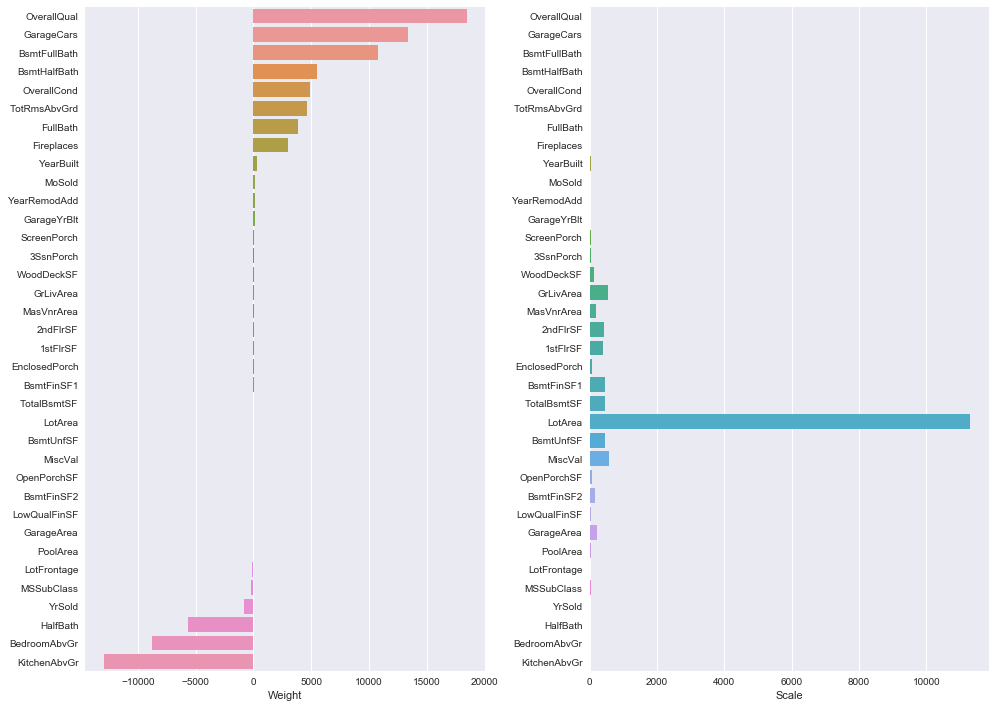

In [27]:
show_weights(numeric_features, model.coef_, X_train[numeric_features].std())

Будем масштабировать наши признаки перед обучением модели. Это, среди, прочего, сделает нашу регуляризацию более честной: теперь все признаки будут регуляризоваться в равной степени. 

Для этого воспользуемся трансформером [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html). Трансформеры в `sklearn` имеют методы `fit` и `transform` (а еще `fit_transform`). Метод `fit` принимает на вход обучающую выборку и считает по ней необходимые значения (например статистики, как `StandardScaler`: среднее и стандартное отклонение каждого из признаков). `transform` применяет преобразование к переданной выборке.

In [28]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[numeric_features])
X_test_scaled = scaler.transform(X_test[numeric_features])

model = Ridge()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
y_train_pred = model.predict(X_train_scaled)

print("Test RMSE = %.4f" % rmse(y_test, y_pred))
print("Train RMSE = %.4f" % rmse(y_train, y_train_pred))

Test RMSE = 32085.3150
Train RMSE = 35631.2160


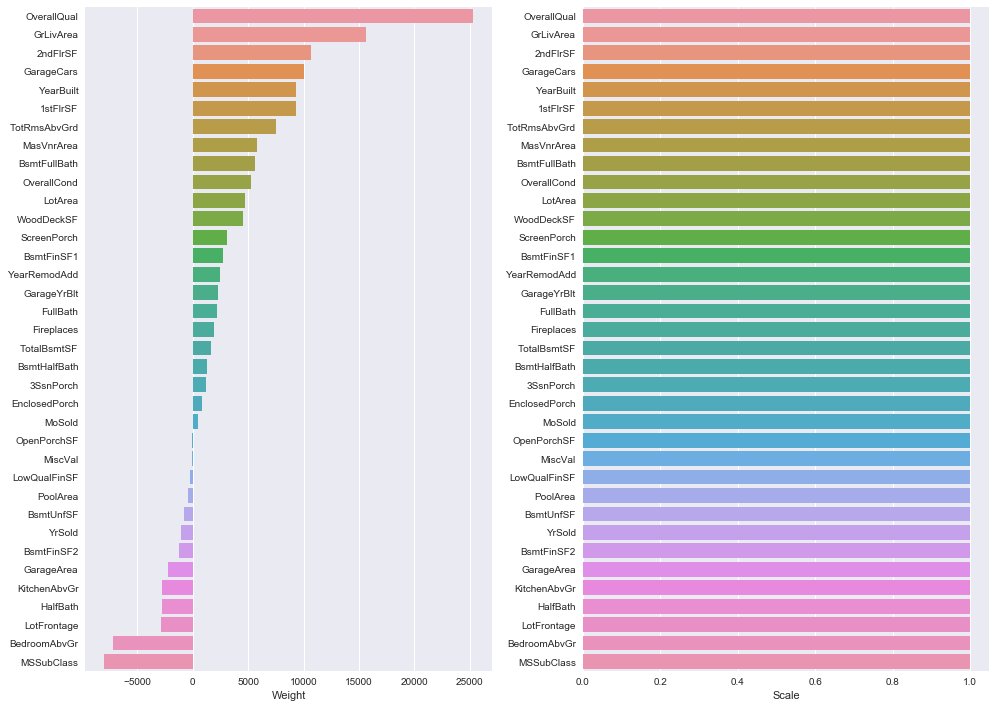

In [29]:
scales = pd.Series(data=X_train_scaled.std(axis=0), index=numeric_features)
show_weights(numeric_features, model.coef_, scales)

Наряду с параметрами (веса $w$, $w_0$), которые модель оптимизирует на этапе обучения, у модели есть и гипермараметры. У нашей модели это `alpha` - коэффициент регуляризации. Подбирают его обычно по сетке, измеряя качество на валидационной (не тестовой) выборке или с помощью кросс-валидации. Посмотрим, как это можно сделать (заметьте, что мы перебираем `alpha` по логарифмической сетке, чтобы узнать оптимальный порядок величины)

Best alpha = 297.6351


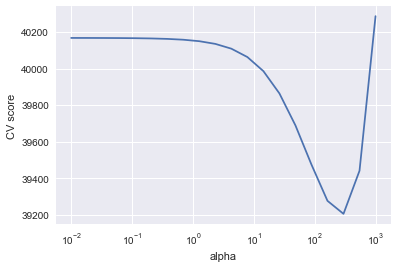

In [30]:
from sklearn.model_selection import GridSearchCV

alphas = np.logspace(-2, 3, 20)
searcher = GridSearchCV(Ridge(), [{"alpha": alphas}], scoring=rmse_scorer, cv=10)
searcher.fit(X_train_scaled, y_train)

best_alpha = searcher.best_params_["alpha"]
print("Best alpha = %.4f" % best_alpha)

plt.plot(alphas, -searcher.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("CV score")

**Вопрос**: Почему мы не подбираем коэффициент регуляризации по обучающей выборке? По тестовой выборке?

Попробуем обучить модель с подобранным коэффициентом регуляризации. Заодно воспользуемся очень удобным классом [`Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html): обучение модели часто представляется как последовательность некоторых действий с обучающей и тестовой выборками (например, сначала нужно отмасштабировать выборку (причем для обучающей выборки нужно применить метод `fit`, а для тестовой - `transform`), а затем обучить/применить модель (для обучающей `fit`, а для тестовой - `predict`). `Pipeline` позволяет хранить эту последовательность шагов и корректно обрабатывает разные типы выборок: и обучающую, и тестовую.

In [31]:
from sklearn.pipeline import Pipeline

simple_pipeline = Pipeline([
    ('scaling', StandardScaler()),
    ('regression', Ridge(best_alpha))
])

model = simple_pipeline.fit(X_train[numeric_features], y_train)
y_pred = model.predict(X_test[numeric_features])
print("Test RMSE = %.4f" % rmse(y_test, y_pred))

Test RMSE = 31703.3590


# Часть 3. Работаем с категориальными признаками

Сейчас мы явно вытягиваем из данных не всю информацию, что у нас есть, просто потому, что мы не используем часть признаков. Эти признаки в датасете закодированы строками, каждый из них обозначает некоторую категорию. Такие признаки называются категориальными. Давайте выделим такие признаки и сразу заполним пропуски в них специальным значением (то, что у признака пропущено значение, само по себе может быть хорошим признаком).

In [32]:
categorical = list(X_train.dtypes[X_train.dtypes == "object"].index)
X_train[categorical] = X_train[categorical].fillna("NotGiven")
X_test[categorical] = X_test[categorical].fillna("NotGiven")

In [33]:
X_train[categorical].sample(5)

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
184,RL,Pave,NotGiven,IR1,Lvl,AllPub,Inside,Gtl,BrkSide,RRAn,...,Attchd,Unf,TA,TA,Y,NotGiven,MnPrv,NotGiven,WD,Normal
837,RM,Pave,NotGiven,Reg,Lvl,AllPub,Inside,Gtl,BrDale,Norm,...,Detchd,Unf,TA,TA,Y,NotGiven,NotGiven,NotGiven,WD,Normal
1094,RL,Pave,NotGiven,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,Attchd,Fin,TA,TA,Y,NotGiven,NotGiven,NotGiven,WD,Normal
1291,RM,Pave,NotGiven,Reg,Lvl,AllPub,Inside,Gtl,BrDale,Norm,...,Detchd,Unf,TA,TA,Y,NotGiven,NotGiven,NotGiven,WD,Normal
436,RM,Pave,NotGiven,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,...,Detchd,Unf,TA,TA,Y,NotGiven,NotGiven,NotGiven,WD,Normal


Сейчас нам нужно как-то закодировать эти категориальные признаки числами, ведь линейная модель не может работать с такими абстракциями. Два стандартных трансформера из `sklearn` для работы с категориальными признаками - [`LabelEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) (просто перенумеровывает значения признака натуральными числами) и [`OneHotEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html).

`OneHotEncoder` ставит в соответствие каждому признаку целый вектор, состоящий из нулей и одной единицы (которая стоит на месте, соответствующем принимаемому значению, таким образом кодируя его).

**Вопрос**: Проинтерпретируйте, что означают веса модели перед OneHot-кодированными признаками. Почему пользоваться `LabelEncoder` в случае линейной модели - скорее плохой вариант? Какие недостатки есть у OneHot-кодирования?

In [ ]:
! conda install -c conda-forge scikit-learn

In [34]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Test RMSE = %.4f" % rmse(y_test, y_pred))

ModuleNotFoundError: No module named 'sklearn.compose'

**Вопрос**: Как вы думаете, почему мы не производим скейлинг OneHot-кодированных признаков?

Посмотрим на размеры матрицы после OneHot-кодирования:

In [23]:
print("Size before OneHot:", X_train.shape)
print("Size after OneHot:", column_transformer.transform(X_train).shape)

Size before OneHot: (1022, 79)
Size after OneHot: (1022, 294)


Как видим, количество признаков увеличилось более, чем в 3 раза. Это может повысить риски переобучиться: соотношение количества объектов к количеству признаков сильно сократилось.

Попытаемся обучить линейную регрессию с $\ell_1$-регуляризатором. На лекциях вы узнаете, что $\ell_1$-регуляризатор разреживает признаковое пространство, иными словами, такая модель зануляет часть весов.

In [24]:
from sklearn.linear_model import Lasso

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

lasso_pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Lasso())
])

model = lasso_pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("RMSE = %.4f" % rmse(y_test, y_pred))

RMSE = 26468.4015


In [25]:
ridge_zeros = np.sum(pipeline.steps[-1][-1].coef_ == 0)
lasso_zeros = np.sum(lasso_pipeline.steps[-1][-1].coef_ == 0)
print("Zero weights in Ridge:", ridge_zeros)
print("Zero weights in Lasso:", lasso_zeros)

Zero weights in Ridge: 0
Zero weights in Lasso: 29


Подберем для нашей модели оптимальный коэффициент регуляризации. Обратите внимание, как перебираются параметры у `Pipeline`

Best alpha = 263.6651


/usr/local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Text(0, 0.5, 'CV score')

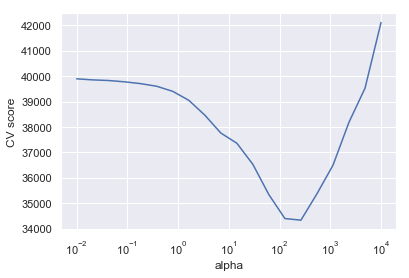

In [26]:
alphas = np.logspace(-2, 4, 20)
searcher = GridSearchCV(lasso_pipeline, [{"regression__alpha": alphas}], scoring=rmse_scorer, cv=10)
searcher.fit(X_train, y_train)

best_alpha = searcher.best_params_["regression__alpha"]
print("Best alpha = %.4f" % best_alpha)

plt.plot(alphas, -searcher.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("CV score")

In [27]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Lasso(best_alpha))
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Test RMSE = %.4f" % rmse(y_test, y_pred))

Test RMSE = 25642.6115


In [28]:
lasso_zeros = np.sum(pipeline.steps[-1][-1].coef_ == 0)
print("Zero weights in Lasso:", lasso_zeros)

Zero weights in Lasso: 218


Иногда очень полезно посмотреть на распределение остатков. Нарисуем гистограмму распределения квадратичной ошибки на обучающих объектах:

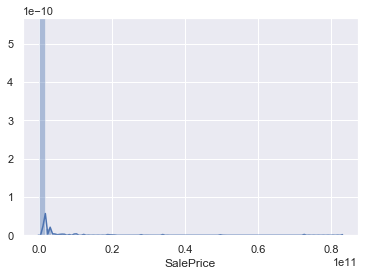

In [29]:
error = (y_train - model.predict(X_train)) ** 2
sns.distplot(error)

Как видно из гистограммы, есть примеры с очень большими остатками. Попробуем их выбросить из обучающей выборки. Например, выбросим примеры, остаток у которых больше 0.95-квантили

In [30]:
mask = (error < np.quantile(error, 0.95))

In [31]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Lasso(best_alpha))
])

model = pipeline.fit(X_train[mask], y_train[mask])
y_pred = model.predict(X_test)
print("Test RMSE = %.4f" % rmse(y_test, y_pred))

Test RMSE = 24963.5922


In [32]:
X_train = X_train[mask]
y_train = y_train[mask]

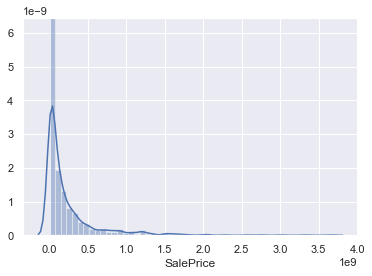

In [33]:
error = (y_train - model.predict(X_train)) ** 2
sns.distplot(error)

Видим, что качество модели заметно улучшилось! Также бывает очень полезно посмотреть на примеры с большими остатками и попытаться понять, почему же модель на них так сильно ошибается: это может дать понимание, как модель можно улучшить.